In [1]:
import difflib
import itertools
import json
import math
import os
import re
import traceback
from collections import Counter, defaultdict
from dataclasses import asdict, dataclass, field
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from termcolor import colored, cprint
from uncertainties import ufloat

from utils import loadRecombsFromFileList, validateAndReturn

In [2]:
json_dir = Path().parent / 'data/json'
recombination_files = sorted(os.listdir(json_dir))
print(recombination_files)

['00001.json', '00002.json', '00003.json', '00004.json', '00005.json', '00006.json', '00007.json', '00008.json', '00009.json', '00010.json', '00011.json', '00012.json', '00013.json', '00014.json', '00015.json', '00016.json', '00017.json', '00018.json', '00019.json', '00020.json', '00021.json', '00022.json', '00023.json', '00024.json', '00025.json', '00026.json', '00027.json', '00028.json', '00029.json', '00030.json', '00031.json', '00032.json', '00033.json', '00034.json', '00035.json', '00036.json', '00037.json', '00038.json', '00039.json', '00040.json', '00041.json', '00042.json', '00043.json', '00044.json', '00045.json', '00046.json', '00047.json', '00048.json', '00049.json', '00050.json', '00051.json', '00052.json', '00053.json', '00054.json', '00055.json', '00056.json', '00057.json', '00058.json', '00059.json', '00060.json', '00061.json', '00062.json', '00063.json', '00064.json', '00065.json', '00066.json', '00067.json', '00068.json', '00069.json', '00070.json', '00071.json', '0007

In [3]:
recombination_files_full = [json_dir / name for name in recombination_files]
recombs = loadRecombsFromFileList(recombination_files_full)

for fpath in list(recombs.keys())[-3:]:
    print(recombs[fpath]['input1'])
    cprint('+', 'green')
    print(recombs[fpath]['input2'])
    cprint('=', 'green')
    print(recombs[fpath]['output'])
    print()

PoEItem(iclass='One Hand Axes', rarity='Magic', name='', base="Conqueror's Infernal Axe", traits={'Physical Damage': 109.5, 'Critical Strike Chance': 0.05, 'Attacks per Second': 1.3, 'Weapon Range': 1.1}, req=PoEReq(level=69, dex=76, str=158, int=0), sockets=PoESocket(short='R G'), ilvl=86, mods=[PoEMod(category='Prefix Modifier', title="Conqueror's", tier=3, tags=['Damage', 'Physical', 'Attack'], effects=[PoEEffect(actual_stats=[61.0], ranges=[[55.0, 64.0]], description='X% increased Physical Damage', comment_lines=[]), PoEEffect(actual_stats=[135.0], ranges=[[124.0, 149.0]], description='+X to Accuracy Rating', comment_lines=[])], doubled=[], kept=[], requirements=None)], special_types=['Elder Item'])
+
PoEItem(iclass='One Hand Axes', rarity='Rare', name='Morbid Rend', base='Reaver Axe', traits={'Physical Damage': 101.5, 'Critical Strike Chance': 0.05, 'Attacks per Second': 1.2, 'Weapon Range': 1.1}, req=PoEReq(level=61, dex=57, str=167, int=0), sockets=PoESocket(short='R-R'), ilvl=8

In [4]:
# Hypothesis testing

In [5]:
# Helper functions
def displayRecomb(recomb_dict):
    print(recomb_dict['input1'])
    cprint('+', 'green')
    print(recomb_dict['input2'])
    cprint('=', 'green')
    print(recomb_dict['output'])
    print()

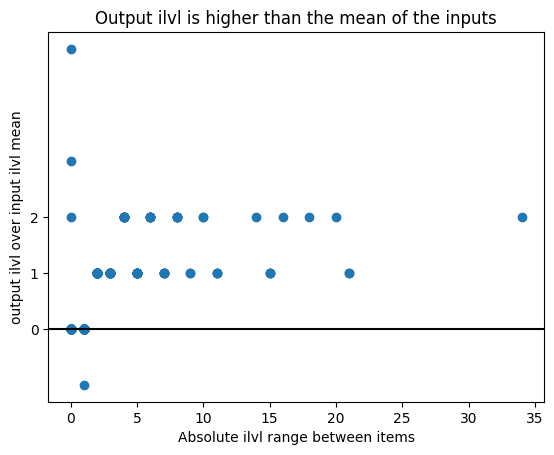

In [6]:
# 1. Is output ilvl always (i1+i2)/2?
x_irange = []
y_expectdelta = []
for fpath in recombination_files:
    data = recombs[fpath]
    i1 = data['input1'].ilvl
    i2 = data['input2'].ilvl
    o1 = data['output'].ilvl
    irange = i2 - i1
    x_irange.append(abs(irange))
    expected = math.ceil((i1 + i2) / 2)
    y_expectdelta.append(o1 - expected)

plt.axhline(0, c='k')
plt.title('Output ilvl is higher than the mean of the inputs')
plt.ylabel('output ilvl over input ilvl mean')
plt.xlabel('Absolute ilvl range between items')
plt.yticks([0, 1, 2])
plt.scatter(x_irange, y_expectdelta)
plt.show()

In [7]:
# 2. Is left/right favored more? (should be a normal distribution)
left, right = 0, 0
ambiguous = 0
for fpath in recombination_files:
    # Check output base type vs i1/i2
    data = recombs[fpath]
    ot = data['output'].base
    i1t = data['input1'].base
    i2t = data['input2'].base

    if ot == i1t and ot == i2t:
        ambiguous += 1
    elif ot == i1t and ot != i2t:
        left += 1
    elif ot != i1t and ot == i2t:
        right += 1
    else:
        # Attempt to infer using string overlap
        # strip "of the X" first to avoid spurious results
        try:
            i1t_s = validateAndReturn(i1t, r"^([\w\s\-']*?)( of the .*)?$")[0][0]
            i2t_s = validateAndReturn(i2t, r"^([\w\s\-']*?)( of the .*)?$")[0][0]
            ot_s = validateAndReturn(ot, r"^([\w\s\-']*?)( of the .*)?$")[0][0]
        except Exception as e:
            print(fpath)
            raise
        
        s1 = difflib.SequenceMatcher(None, i1t_s, ot_s)
        left_overlap = s1.find_longest_match()
        s2 = difflib.SequenceMatcher(None, i2t_s, ot_s)
        right_overlap = s2.find_longest_match()

        lefto = left_overlap.size
        righto = right_overlap.size
        if lefto == righto:
            ambiguous += 1
        elif lefto > righto:
            left += 1
        else:
            right += 1

print(left, right)
print(left + right)
# This is pretty much in the realm of expectation https://www.wolframalpha.com/input?i=probability+of+11+or+fewer+heads+in+26+flips

104 111
215


In [8]:
# 3. How many prefixes/suffixes are on the final item compared to the pool?
#    Pool as described here: https://www.reddit.com/r/pathofexile/comments/v0nm0c/the_complete_guide_to_recombinators/
before_after = defaultdict(list)
for fpath in recombination_files:
    data = recombs[fpath]
    countSlots = lambda item, slot: sum([m.getSlot() == slot for m in item.mods])
    input_prefix_count = countSlots(data['input1'], 'Prefix') + countSlots(data['input2'], 'Prefix')
    input_suffix_count = countSlots(data['input1'], 'Suffix') + countSlots(data['input2'], 'Suffix')
    output_prefix_count = countSlots(data['output'], 'Prefix')
    output_suffix_count = countSlots(data['output'], 'Suffix')
    
    before_after[input_prefix_count].append(output_prefix_count)
    before_after[input_suffix_count].append(output_suffix_count)

for in_pool in sorted(list(before_after.keys())):
    if in_pool == 0: # Pretty obvious what happens here
        continue
    
    freq = Counter(before_after[in_pool])
    total = freq.total()
    cprint(f'{in_pool} mod(s) in pool (n={total} so ~±{int(round(100/total, 0))}%)', 'white', attrs=['bold'])
    for outcome in sorted(list(freq.keys()), reverse=True):
        percent = int(round(freq[outcome] / total * 100, 0))
        print(f'{percent}% to choose {outcome} mods')
    print()

1 mod(s) in pool (n=60 so ~±2%)
58% to choose 1 mods
42% to choose 0 mods

2 mod(s) in pool (n=82 so ~±1%)
23% to choose 2 mods
74% to choose 1 mods
2% to choose 0 mods

3 mod(s) in pool (n=94 so ~±1%)
4% to choose 3 mods
57% to choose 2 mods
38% to choose 1 mods

4 mod(s) in pool (n=121 so ~±1%)
36% to choose 3 mods
53% to choose 2 mods
12% to choose 1 mods

5 mod(s) in pool (n=115 so ~±1%)
56% to choose 3 mods
44% to choose 2 mods

6 mod(s) in pool (n=73 so ~±1%)
74% to choose 3 mods
26% to choose 2 mods



In [150]:
# 4. Does doubling work?
# According to https://www.reddit.com/r/pathofexile/comments/v0nm0c/the_complete_guide_to_recombinators/
#    you want to "double" modgroups by having the same modgroup on both items.
#    This allows you to keep "desired" mods more often than if they are on just one item.
#    (This is only for "desired" mod selection, it doesn't help with selecting the intended tier.)

# Compare % keep with non-doubled vs doubled mods
nondouble_total = 0
nondouble_keep = 0
double_total = 0
double_keep = 0

double_kept_lower = 0
double_kept_higher = 0
double_same_tier = 0
double_ambiguous = 0
for fpath in recombination_files:
    data = recombs[fpath]

    for item in ['input1', 'input2']:
        for m in [x for x in data[item].mods if x.getSlot() in ['Prefix', 'Suffix']]:
            if m.doubled:
                double_total += 1
                if m.kept:
                    double_keep += 1

                    if item == 'input2':
                        # Compare with input1 and see whether higher or lower tier was kept
                        i1_mod = data['input1'].mods[m.doubled[0][0]]
                        # print(i1_mod)
                        i1_tier = i1_mod.tier

                        if i1_tier is None:
                            # TODO: Some implicits are leaking into here
                            continue
                        
                        if i1_tier == m.tier:
                            double_same_tier += 1
                        else:
                            if abs(i1_tier - m.tier) == 1:
                                double_ambiguous += 1
                            else:
                                output_mod = data['output'].mods[m.kept[0][1]]
                                if i1_tier > m.tier and output_mod.tier > m.tier:
                                    double_kept_higher += 1
                                elif i1_tier < m.tier and output_mod.tier < m.tier:
                                    double_kept_higher += 1
                                else:
                                    double_kept_lower += 1
            else:
                nondouble_total += 1
                if m.kept:
                    nondouble_keep += 1

print(f'Average nondouble keep percentage: {int(round(nondouble_keep / nondouble_total*100, 0))}% ({nondouble_keep}/{nondouble_total})')
print(f'Average double keep percentage: {int(round(double_keep / double_total*100, 0))}% ({double_keep}/{double_total})')
print()
print(f'Higher tier mod kept: {double_kept_higher}/{double_kept_higher + double_kept_lower}')

Average nondouble keep percentage: 45% (656/1470)
Average double keep percentage: 84% (256/304)

Higher tier mod kept: 35/68


In [151]:
# So what is the crafting procedure given this across different numbers of desired mods?
# 1 desired mod on a new base (40% it)
# 2 desired mods on a new base
#  A. get one desired mod onto two desired bases (2x 40%), then recombine (?)
#  B. get two desired mods onto non desired base (?), then recombine (?)

# (assume even chance of each modifier being selected)
# A)
for desired_mod_count in range(1, 4):
    cprint(f'{desired_mod_count} desired mod(s)', 'white', attrs=['bold'])
    
    for in_pool in sorted(list(before_after.keys())):
        if in_pool == 0: # Pretty obvious what happens here
            continue

        if in_pool < desired_mod_count:
            continue
        if in_pool > 6:
            break
        
        freq = Counter(before_after[in_pool])
        total = freq.total()

        hit_pc = 0
        miss_pc = 0
        for outcome in sorted(list(freq.keys()), reverse=True):
            # Here meaning how often N prefixes/suffixes are on the output item afterwards
            outcome_likelihood = ufloat(freq[outcome] / total, 1 / total)

            # Calculate how often the desired mod specifically is kept
            # This could be done using actual data, or I could just assume mods are equally weighted as a prior and do it that way (which is what I did)
            # Doing it the lazy way because modern computers are strong
            possible_selections = list(itertools.combinations(range(in_pool), outcome))
            matching = 0
            for selection in possible_selections:
                if all([mod_number in selection for mod_number in range(desired_mod_count)]):
                    matching += 1
            desired_likelihood = matching / len(possible_selections)
            # print(possible_selections)
            # print(f'{in_pool} choose {outcome}', desired_likelihood)
            
            # Leechedpercent = int(round(freq[outcome] / total * 100, 0))
            # print(f'{percent}% to choose {outcome} mods')

            # print(outcome, ':', outcome_likelihood, '|', desired_likelihood)

            hit_pc += outcome_likelihood * desired_likelihood
            miss_pc += outcome_likelihood * (1 - desired_likelihood)

        print(colored(f'Pool size {in_pool}:', 'yellow'), f'{hit_pc*100}% (n={total})')
    print()
        # cprint(f'{in_pool} mod(s) in pool (n={total} so ~±{int(round(100/total, 0))}%)', 'white', attrs=['bold'])
        # for outcome in sorted(list(freq.keys()), reverse=True):
        #     percent = int(round(freq[outcome] / total * 100, 0))
        #     print(f'{percent}% to choose {outcome} mods')
        # print()

# If 2 desired, best recombinator scenario is ???

1 desired mod(s)
Pool size 1: 60.7+/-1.8% (n=56)
Pool size 2: 61.3+/-1.5% (n=75)
Pool size 3: 55.2+/-1.5% (n=84)
Pool size 4: 57.1+/-0.9% (n=105)
Pool size 5: 50.8+/-0.7% (n=100)
Pool size 6: 45.7+/-0.9% (n=66)

2 desired mod(s)
Pool size 2: 25.3+/-1.3% (n=75)
Pool size 3: 23.4+/-1.3% (n=84)
Pool size 4: 27.6+/-0.5% (n=105)
Pool size 5: 20.80+/-0.32% (n=100)
Pool size 6: 16.57+/-0.32% (n=66)

3 desired mod(s)
Pool size 3: 4.8+/-1.2% (n=84)
Pool size 4: 9.29+/-0.24% (n=105)
Pool size 5: 5.40+/-0.10% (n=100)
Pool size 6: 3.71+/-0.08% (n=66)



In [9]:
# 5. When combining two items with shared mods of different tiers, how often is the higher tier selected?
freq_raw = []
for fpath in recombination_files:
    data = recombs[fpath]

    for m in data['input1'].mods:
        if m.doubled and m.kept:
            left_tier = m.tier
            right_mod = data['input2'].mods[m.doubled[0][1]]
            right_tier = right_mod.tier
            kept_mod = data['output'].mods[m.kept[0][1]]
            kept_tier = kept_mod.tier

            # print(f'Kept "{kept_mod.effects[0].description}" from {fpath} ({left_tier} {right_tier} {kept_tier})')

            freq_raw.append((left_tier, right_tier, kept_tier))

# Basic "keep higher or not"
frequency = Counter(freq_raw)
tier_number_drop = []
# Note that "lower" and "higher" are in Integer coordinates, meaning T4 -> T5 is "higher"
lower = 0
higher = 0
ambiguous = 0
upgrades = 0
for incident, value in frequency.items():
    l, r, o = incident
    
    if l == r or l is None:
        # TODO: Should None happen?
        continue

    if abs(l - r) == 1 and o == min([l, r]):
        # tiers are [5, 6], 5 is selected. Cannot tell whether it was 5 selection or 6 selection and then upgrade
        ambiguous += value
        continue
    
    if o != l and o != r:
        # Mod upgrade happened (should be 5% according to in-game tooltip)
        # We can still determine lo/hi depending on which one it is +1 tier from
        upgrades += 1
        if l - 1 == o:
            if l < r:
                lower += value
            else:
                higher += value
        elif r - 1 == o:
            if r < l:
                lower += value
            else:
                higher += value
        else:
            cprint('Apparently more than +1 is possible', 'blue')
        continue

    # No mod upgrade, so can just directly compare
    tier_number_change_from_highest = o - max([l, r])
    if tier_number_change_from_highest == 0:
        lower += value
    elif tier_number_change_from_highest < 0:
        higher += value

    lr_range = abs(l-r)
    tier_number_drop.append(int(math.copysign(lr_range, tier_number_change_from_highest)))

# Note that "lower" and "higher" are notated in Integer space, but tiers are better the "lower" they are
# So I convert coordinate spaces before printing
def pc0(value, total):
    if total == 0:
        return '?'
    return int(round(value / total * 100, 0))
total = lower + higher
print(f'Better tier: {pc0(lower, total)}% ({lower}/{total})')
print(f'Worse tier: {pc0(higher, total)}% ({higher}/{total})')
print(f'Tier upgrades: {pc0(upgrades, total)}% ({upgrades}/{total})')
print(f'Ambiguous: {ambiguous}')
print()
print(f'Chance to jump +X tiers (low confidence, n={len(tier_number_drop)})')
tj_freq = Counter(tier_number_drop)
# print(tj_freq)
for i in range(1, 13):
    tj_total = tj_freq[i] + tj_freq[-i]
    comment = ''
    positive_count_bonus = 0
    if i == 1:
        positive_count_bonus += ambiguous
        tj_total += ambiguous
        comment = f' (n={ambiguous} were ambiguous but added in here to avoid confusion, actual positive count is 5% lower)'
    print(f'Range {str(i).rjust(2)}: {colored("↑", "green")}{pc0(tj_freq[-i] + positive_count_bonus, tj_total)}% {colored("↓", "red")}{pc0(tj_freq[i], tj_total)}% (n={tj_total}){comment}')

# frequency

Better tier: 59% (55/94)
Worse tier: 41% (39/94)
Tier upgrades: 5% (5/94)
Ambiguous: 16

Chance to jump +X tiers (low confidence, n=66)
Range  1: ↑59% ↓41% (n=27) (n=16 were ambiguous but added in here to avoid confusion, actual positive count is 5% lower)
Range  2: ↑54% ↓46% (n=13)
Range  3: ↑50% ↓50% (n=16)
Range  4: ↑38% ↓62% (n=8)
Range  5: ↑50% ↓50% (n=6)
Range  6: ↑40% ↓60% (n=5)
Range  7: ↑33% ↓67% (n=6)
Range  8: ↑100% ↓0% (n=1)
Range  9: ↑?% ↓?% (n=0)
Range 10: ↑?% ↓?% (n=0)
Range 11: ↑?% ↓?% (n=0)
Range 12: ↑?% ↓?% (n=0)


In [10]:
# ^^ How much of this is due to ilvl/basetype incompatibility?
# TODO:

In [11]:
# How often are TX mods kept?
# (There must be other mod tiers to select from in said pool)
kept_count = Counter()
total_count = Counter()
for fpath in recombination_files:
    data = recombs[fpath]

    non_implicit_1 = [x for x in data['input1'].mods if x.getSlot() != 'Implicit']
    non_implicit_2 = [x for x in data['input2'].mods if x.getSlot() != 'Implicit']
    prefix_pool = [x for x in non_implicit_1 if x.getSlot() == 'Prefix'] + [x for x in non_implicit_2 if x.getSlot() == 'Prefix']
    suffix_pool = [x for x in non_implicit_1 if x.getSlot() == 'Suffix'] + [x for x in non_implicit_2 if x.getSlot() == 'Suffix']
    unique_prefix_tiers = set([x.tier for x in prefix_pool])
    unique_suffix_tiers = set([x.tier for x in suffix_pool])
    
    if len(unique_prefix_tiers) > 1:
        for m in prefix_pool:
            total_count[m.tier] += 1
            if m.kept:
                kept_count[m.tier] += 1
    if len(unique_suffix_tiers) > 1:
        for m in suffix_pool:
            total_count[m.tier] += 1
            if m.kept:
                kept_count[m.tier] += 1

del kept_count[None]
del total_count[None]
for mod_tier, total in sorted(total_count.items()):
    print(f'T{mod_tier}'.rjust(3), f'kept {str(pc0(kept_count[mod_tier], total)).rjust(4)}% of the time ({kept_count[mod_tier]}/{total})')

 T0 kept   64% of the time (47/74)
 T1 kept   30% of the time (134/441)
 T2 kept   54% of the time (144/269)
 T3 kept   48% of the time (94/194)
 T4 kept   55% of the time (66/121)
 T5 kept   59% of the time (94/160)
 T6 kept   59% of the time (106/180)
 T7 kept   59% of the time (93/157)
 T8 kept   64% of the time (92/144)
 T9 kept   67% of the time (49/73)
T10 kept   70% of the time (30/43)
T11 kept   50% of the time (5/10)
T12 kept   55% of the time (6/11)
T13 kept   40% of the time (2/5)


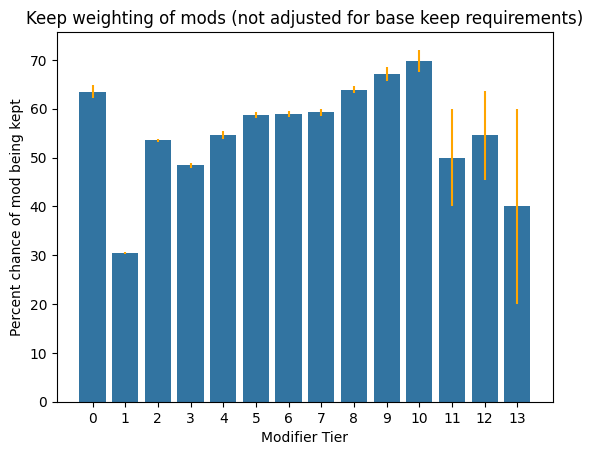

In [17]:
# Plot of above data
df_list = [{
    'mod_tier': mod_tier,
    'percent_keep': kept_count[mod_tier] / total * 100,
    'error_est': 100/total,
} for mod_tier, total in total_count.items()]
df = pd.DataFrame(df_list)
df = df.sort_values('mod_tier')
# display(df)
pp_ax = sns.barplot(data=df, x='mod_tier', y='percent_keep')
pp_ax.errorbar(x=df['mod_tier'], y=df['percent_keep'], yerr=df['error_est'], fmt='none', color='orange')
plt.ylabel('Percent chance of mod being kept')
plt.xlabel('Modifier Tier')
plt.title('Keep weighting of mods (not adjusted for base keep requirements)')
plt.show()

In [13]:
# How often are crafted mods kept?
kept = 0
not_kept = 0
for fpath in recombination_files:
    data = recombs[fpath]

    for item_type in ['input1', 'input2']:
        for m in data[item_type].mods:
            if 'Crafted' in m.category:
                # print(m.category)
                if m.kept:
                    kept += 1
                else:
                    not_kept += 1

total = kept + not_kept
print(f'Crafted mods are kept {round(kept / (total) * 100, 1)}±{round(1/total*100, 1)}% ({kept}/{total}) of the time')

# TODO: Crafted mods have a separate "rank" system, not sure how it corresponds to "tier"
# Need to measure this

Crafted mods are kept 58.1±2.3% (25/43) of the time


In [14]:
# Create table of all cross outcomes (assuming independent modifiers)
from IPython.display import display, HTML
from pprint import pformat

def boxprint(*args):
    for arg in args:
        display(HTML('<pre style="white-space: pre !important;">{}</pre>'.format(pformat(arg))))

historical_outcomes = defaultdict(lambda: dict())
for in_pool in sorted(list(before_after.keys())):
    if in_pool > 6:
        break
    
    freq = Counter(before_after[in_pool])
    total = freq.total()
    
    for outcome in sorted(list(freq.keys())):
        percent = round(freq[outcome] / total, 3)
        historical_outcomes[in_pool][outcome] = percent

possible_states = list(itertools.product(range(4), range(4)))
headers = ['', *[str(x) for x in possible_states]]
rows = []
for left_state in possible_states:
    r = []
    r.append(f'{left_state}')
    for right_state in possible_states:
        prefix_pool_size = left_state[0] + right_state[0]
        suffix_pool_size = left_state[1] + right_state[1]

        post_combine_outcomes = list(itertools.product(
            historical_outcomes[prefix_pool_size].items(),
            historical_outcomes[suffix_pool_size].items(),
        ))
        cellstate = []
        for o in post_combine_outcomes:
            cellstate.append((round(o[0][1] * o[1][1] * 100, 1), (o[0][0], o[1][0])))
        cellstate.sort(key=lambda x: (-x[0], x[1]))
        cellstate = [f'{str(x[0]).ljust(4)}% {x[1]}' for x in cellstate]
        cellstate = '\n'.join(cellstate)
        r.append(cellstate)

    rows.append(r)

tabulate.PRESERVE_WHITESPACE = True
print(tabulate(rows, headers, tablefmt='grid', disable_numparse=True, maxcolwidths=14))

+--------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|        | (0, 0)        | (0, 1)       | (0, 2)       | (0, 3)       | (1, 0)       | (1, 1)       | (1, 2)       | (1, 3)       | (2, 0)       | (2, 1)       | (2, 2)       | (2, 3)       | (3, 0)       | (3, 1)       | (3, 2)       | (3, 3)       |
+========+===============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
| (0, 0) | 100.0% (0, 0) | 58.3% (0, 1) | 74.4% (0, 1) | 57.4% (0, 2) | 58.3% (1, 0) | 34.0% (1, 1) | 43.4% (1, 1) | 33.5% (1, 2) | 74.4% (1, 0) | 43.4% (1, 1) | 55.4% (1, 1) | 42.7% (1, 2) | 57.4% (2, 0) | 33.5% (2, 1) | 42.7% (2, 1) | 32.9% (

In [15]:
# Same data as above, but sort into "more", "same", and "less" percentages
# "more" = more mods than the max of (prefix, suffix) of the items you started out with (green)
# "same" = same mods as the max of (prefix, suffix) of the items you started out with   (yellow)
# "less" = less mods than the max of (prefix, suffix) of the items you started out with (red)
historical_outcomes = defaultdict(lambda: dict())
for in_pool in sorted(list(before_after.keys())):
    if in_pool > 6:
        break
    
    freq = Counter(before_after[in_pool])
    total = freq.total()
    
    for outcome in sorted(list(freq.keys())):
        percent = round(freq[outcome] / total, 3)
        historical_outcomes[in_pool][outcome] = percent

possible_states = list(itertools.product(range(4), range(4)))
headers = ['', *[str(x) for x in possible_states]]
rows = []
for left_state in possible_states:
    r = []
    r.append(f'{left_state}')
    for right_state in possible_states:
        prefix_pool_size = left_state[0] + right_state[0]
        suffix_pool_size = left_state[1] + right_state[1]

        post_combine_outcomes = list(itertools.product(
            historical_outcomes[prefix_pool_size].items(),
            historical_outcomes[suffix_pool_size].items(),
        ))
        cellstate = []
        for o in post_combine_outcomes:
            cellstate.append((round(o[0][1] * o[1][1] * 100, 1), (o[0][0], o[1][0])))

        starting_mods = prefix_pool_size + suffix_pool_size
        max_prefix = max([left_state[0], right_state[0]])
        max_suffix = max([left_state[1], right_state[1]])
        good_bad_pc = {
            'more': 0,
            'same': 0,
            'less': 0,
        }
        for o in cellstate:
            pc, post_mod_state = o

            if (post_mod_state[0] > max_prefix and post_mod_state[1] == max_suffix) or (post_mod_state[1] > max_suffix and post_mod_state[0] == max_prefix):
                # Gained a mod! eg (3, 2) + (3, 1) -> (3, 3)
                good_bad_pc['more'] += pc
            elif post_mod_state[0] == max_prefix and post_mod_state[1] == max_suffix:
                good_bad_pc['same'] += pc
            else:
                good_bad_pc['less'] += pc
            
            # post_mods = post_mod_state[0] + post_mod_state[1]
            # if post_mods > starting_mods / 2:
            #     good_bad_pc['more'] += pc
            # elif post_mods == starting_mods / 2:
            #     good_bad_pc['same'] += pc
            # else:
            #     good_bad_pc['less'] += pc

        cellstate = []
        for category, pc in good_bad_pc.items():
            if category == 'more':
                color = 'green'
            elif category == 'same':
                color = 'yellow'
            else:
                color = 'red'
            pc = round(pc, 1)
            attrs = []
            if pc > 50:
                attrs = ['bold', 'underline']
            if pc > 0:
                cellstate.append(colored(f'{category.title()} {str(pc).ljust(4)}%', color, attrs=attrs))
            else:
                cellstate.append('​') # Zero width space so More/Less rows line up

        cellstate = '\n'.join(cellstate)
        r.append(cellstate)

    rows.append(r)

tabulate.PRESERVE_WHITESPACE = True
print(tabulate(rows, headers, tablefmt='grid', disable_numparse=True))

+--------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|        | (0, 0)      | (0, 1)     | (0, 2)     | (0, 3)     | (1, 0)     | (1, 1)     | (1, 2)     | (1, 3)     | (2, 0)     | (2, 1)     | (2, 2)     | (2, 3)     | (3, 0)     | (3, 1)     | (3, 2)     | (3, 3)     |
+========+=============+============+============+============+============+============+============+============+============+============+============+============+============+============+============+============+
| (0, 0) | ​            | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           | ​           |
|        | Same 100.0% | Same 58.3% | Same 23.2% | Same 4.3 % | Same 58.3% | Same 34.0% | Same 13.5% | S

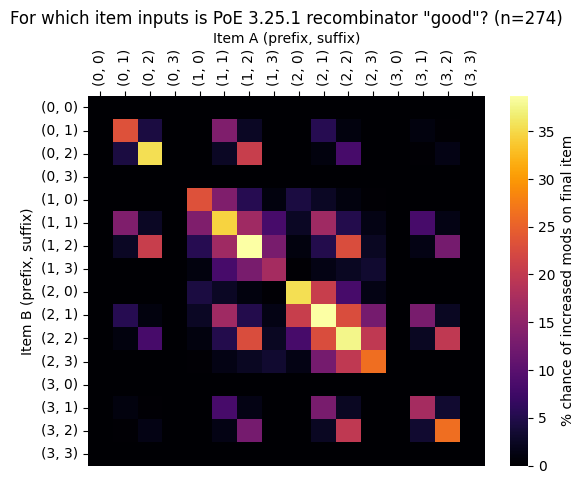

In [16]:
# Same data as above, but compute a "total value" metric of (2 * more) + same - less
# This way we can get a single value and heatmap it :D
historical_outcomes = defaultdict(lambda: dict())
for in_pool in sorted(list(before_after.keys())):
    if in_pool > 6:
        break
    
    freq = Counter(before_after[in_pool])
    total = freq.total()
    
    for outcome in sorted(list(freq.keys())):
        percent = round(freq[outcome] / total, 3)
        historical_outcomes[in_pool][outcome] = percent

possible_states = list(itertools.product(range(4), range(4)))
headers = ['left item', *[str(x) for x in possible_states]]
rows = []
for left_state in possible_states:
    r = []
    r.append(f'{left_state}')
    for right_state in possible_states:
        prefix_pool_size = left_state[0] + right_state[0]
        suffix_pool_size = left_state[1] + right_state[1]

        post_combine_outcomes = list(itertools.product(
            historical_outcomes[prefix_pool_size].items(),
            historical_outcomes[suffix_pool_size].items(),
        ))
        cellstate = []
        for o in post_combine_outcomes:
            cellstate.append((round(o[0][1] * o[1][1] * 100, 1), (o[0][0], o[1][0])))

        # starting_mods = prefix_pool_size + suffix_pool_size
        # good_bad_pc = {
        #     'more': 0,
        #     'same': 0,
        #     'less': 0,
        # }
        # for o in cellstate:
        #     pc, post_mod_state = o
        #     post_mods = post_mod_state[0] + post_mod_state[1]
        #     if post_mods > starting_mods / 2:
        #         good_bad_pc['more'] += pc
        #     elif post_mods == starting_mods / 2:
        #         good_bad_pc['same'] += pc
        #     else:
        #         good_bad_pc['less'] += pc

        starting_mods = prefix_pool_size + suffix_pool_size
        max_prefix = max([left_state[0], right_state[0]])
        max_suffix = max([left_state[1], right_state[1]])
        good_bad_pc = {
            'more': 0,
            'same': 0,
            'less': 0,
        }
        for o in cellstate:
            pc, post_mod_state = o

            if (post_mod_state[0] > max_prefix and post_mod_state[1] == max_suffix) or (post_mod_state[1] > max_suffix and post_mod_state[0] == max_prefix):
                # Gained a mod! eg (3, 2) + (3, 1) -> (3, 3)
                good_bad_pc['more'] += pc
            elif post_mod_state[0] == max_prefix and post_mod_state[1] == max_suffix:
                good_bad_pc['same'] += pc
            else:
                good_bad_pc['less'] += pc

        metric_score = good_bad_pc['more'] # - 2 * good_bad_pc['less']
        metric_score = round(metric_score, 2)
        r.append(metric_score)

    rows.append(r)

df = pd.DataFrame(rows, columns=headers)
df = df.set_index(keys='left item')
# display(df)

fig, ax = plt.subplots()
sns.heatmap(df, cmap='inferno', ax=ax, cbar_kws={'label': '% chance of increased mods on final item'})
json_dir_parent = json_dir.parent
if json_dir_parent.name == 'old_data':
    patch = '3.25.0'
elif json_dir_parent.name == 'data':
    patch = '3.25.1'
plt.title(f'For which item inputs is PoE {patch} recombinator "good"? (n={len(recombination_files)})')
plt.ylabel('Item B (prefix, suffix)')
plt.xlabel('Item A (prefix, suffix)')
ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, labelrotation=90)
ax.xaxis.set_label_position('top')
plt.show()

# Print top combines and their expected outcomes
# TODO:

In [160]:
# How much doubling is there?
doubled = 0
not_doubled = 0
for fpath in recombination_files:
    data = recombs[fpath]

    for m in data['input1'].mods:
        if m.doubled:
            doubled += 1
        else:
            not_doubled += 1

print(f'{doubled}/{doubled+not_doubled}')

187/970


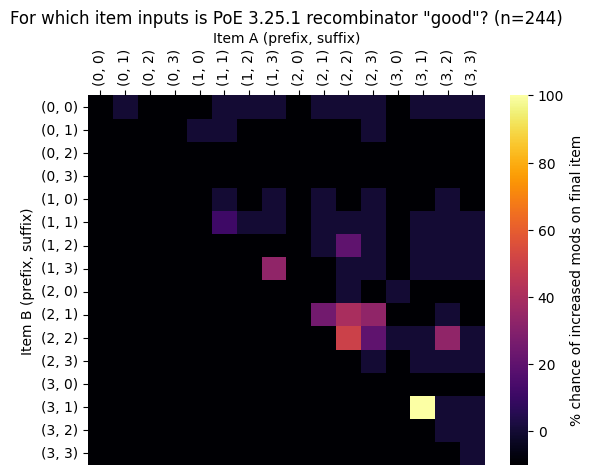

In [161]:
# Same as above chart, but using historical data only, not cross product
recombs_by_pool_cross = defaultdict(list)
countSlots = lambda item, slot: sum([m.getSlot() == slot for m in item.mods])
for fpath in recombination_files:
    data = recombs[fpath]
    input1_prefix_count = countSlots(data['input1'], 'Prefix')
    input2_prefix_count = countSlots(data['input2'], 'Prefix')
    input1_suffix_count = countSlots(data['input1'], 'Suffix')
    input2_suffix_count = countSlots(data['input2'], 'Suffix')
    # output_prefix_count = countSlots(data['output'], 'Prefix')
    # output_suffix_count = countSlots(data['output'], 'Suffix')

    key = tuple(sorted((
        (input1_prefix_count, input1_suffix_count),
        (input2_prefix_count, input2_suffix_count),
    )))
    recombs_by_pool_cross[key].append(data['output'])

# Construct df
actual_df = df.copy()
for col in actual_df.columns:
    actual_df[col].values[:] = -10
    

def strictlyAddModsMetric(cross, outcomes):
    left_state = cross[0]
    right_state = cross[1]
    max_prefix = max([left_state[0], right_state[0]])
    max_suffix = max([left_state[1], right_state[1]])
    outcomes = [(countSlots(x, 'Prefix'), countSlots(x, 'Suffix')) for x in outcomes]
    
    good_bad_pc = {
        'more': 0,
        'same': 0,
        'less': 0,
    }
    for post_mod_state in outcomes:
        if (post_mod_state[0] > max_prefix and post_mod_state[1] == max_suffix) or (post_mod_state[1] > max_suffix and post_mod_state[0] == max_prefix):
            # Gained a mod! eg (3, 2) + (3, 1) -> (3, 3)
            good_bad_pc['more'] += 1
        elif post_mod_state[0] == max_prefix and post_mod_state[1] == max_suffix:
            good_bad_pc['same'] += 1
        else:
            good_bad_pc['less'] += 1
    total = sum(good_bad_pc.values())
    for k, v in good_bad_pc.items():
        good_bad_pc[k] = v / total
    return good_bad_pc['more'] * 100
    # return (2 * good_bad_pc['more'] + good_bad_pc['same']) / len(outcomes)
    

for cross, result_item_list in sorted(recombs_by_pool_cross.items()):
    metric = strictlyAddModsMetric
    actual_df.loc[str(cross[0]), str(cross[1])] = metric(cross, result_item_list)

fig, ax = plt.subplots()
sns.heatmap(actual_df, cmap='inferno', ax=ax, cbar_kws={'label': '% chance of increased mods on final item'})
json_dir_parent = json_dir.parent
if json_dir_parent.name == 'old_data':
    patch = '3.25.0'
elif json_dir_parent.name == 'data':
    patch = '3.25.1'
plt.title(f'For which item inputs is PoE {patch} recombinator "good"? (n={len(recombination_files)})')
plt.ylabel('Item B (prefix, suffix)')
plt.xlabel('Item A (prefix, suffix)')
ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, labelrotation=90)
ax.xaxis.set_label_position('top')
plt.show()

# TODO: Make a more useful chart, "increased mods" is useful but not particularly when we care about desired mods only
# With desired mods I can actually make a solver that takes coherent steps

In [162]:
# 6. What are individual mod weights? (low confidence) Does it seem like it is following a weighting model or a non weighted model?

In [163]:
# 7. Are influences weighted?
raw_frequency = defaultdict(list)
for fpath in recombination_files:
    data = recombs[fpath]

    known_special_types = ['Synthesised Item', 'Corrupted', 'Elder Item', 'Fractured Item', 'Shaper Item', 'Split', 'Crusader Item', 'Warlord Item', 'Redeemer Item']
    
    input1_special = data['input1'].special_types
    input2_special = data['input2'].special_types
    output_special = data['output'].special_types

    if (input1_special or input2_special) and (input1_special != input2_special):
        to_continue = False
        for item_type in ['input1', 'input2', 'output']:
            relevant_special = data[item_type].special_types
            if relevant_special:
                unknown_types = [x for x in relevant_special if x not in known_special_types]
                if unknown_types:
                    cprint(f'Likely parsing error or new type {unknown_types} (from {item_type} from {fpath})', 'yellow')
                    to_continue = True
                    break
        if to_continue:
            continue
        
        key = tuple(sorted((
            tuple(sorted(input1_special)),
            tuple(sorted(input2_special)),
        )))
        raw_frequency[key].append(tuple(sorted(output_special)))

raw_frequency = dict(sorted(raw_frequency.items(), key=lambda x: len(x[1]), reverse=True))
for input_specials, output_special in raw_frequency.items():
    outputs = Counter(output_special)
    total = outputs.total()
    
    cprint(f'{input_specials[0]} + {input_specials[1]} (n={total})', attrs=['bold'])
    for outcome in outputs.most_common():
        print('   ', outcome[1], outcome[0])
    print()

() + ('Elder Item',) (n=23)
    16 ()
    7 ('Elder Item',)

() + ('Split',) (n=13)
    7 ()
    6 ('Split',)

('Elder Item',) + ('Split',) (n=5)
    3 ('Split',)
    2 ('Elder Item',)

() + ('Corrupted',) (n=3)
    2 ('Corrupted',)
    1 ()

() + ('Warlord Item',) (n=3)
    2 ('Warlord Item',)
    1 ()

() + ('Synthesised Item',) (n=2)
    1 ()
    1 ('Synthesised Item',)

('Elder Item',) + ('Fractured Item',) (n=2)
    1 ('Fractured Item',)
    1 ()

() + ('Shaper Item',) (n=2)
    1 ('Shaper Item',)
    1 ()

('Split',) + ('Warlord Item',) (n=1)
    1 ('Split',)

('Corrupted',) + ('Elder Item',) (n=1)
    1 ('Corrupted',)

('Corrupted',) + ('Split',) (n=1)
    1 ('Split',)

() + ('Redeemer Item',) (n=1)
    1 ()

('Elder Item',) + ('Synthesised Item',) (n=1)
    1 ('Elder Item',)



In [ ]:
# 8. Are the mods output strictly in the set of the input mods?